In [1]:
import os

In [2]:
import tensorflow as tf

In [3]:
import sys

In [4]:
import numpy as np

In [5]:
import matplotlib.pyplot as plt

In [74]:
import matplotlib

In [77]:
matplotlib.rc('font', size=15)

In [6]:
from scipy.interpolate import make_interp_spline, BSpline
from scipy.ndimage.filters import gaussian_filter1d

In [ ]:
sys.version

In [ ]:
!pip --version

In [47]:
def read_tf_data(fs):
    steps = []
    precs = []
    recalls = []
    shds = []
    losses = []
    if type(fs) is not list:
        fs = [fs]
    for f in fs:
        it = tf.compat.v1.train.summary_iterator(f)

        # the first seems to be a placeholder
        first = next(it)
        assert first.step == 0
        assert len(first.summary.value) == 0

        for e in it:
            v = e.summary.value[0]
            if v.tag == 'graph/prec':
                precs.append(v.simple_value)
            elif v.tag == 'graph/recall':
                recalls.append(v.simple_value)
            elif v.tag == 'graph/v/shd':
                shds.append(v.simple_value)
            elif v.tag == 'loss':
                steps.append(e.step)
                losses.append(v.simple_value)
            else:
                pass
    res = {}
    steps = np.array(steps)
    precs = np.array(precs)
    recalls = np.array(recalls)
    res['steps'] = steps
    res['precs'] = precs
    res['recalls'] = recalls
    res['losses'] = np.array(losses)
    res['shds'] = np.array(shds)
    return res

In [8]:
type([1,2]) == list

True

# compare EQ CNN FC

In [88]:
def eqcnnfc_tf_name(model, d):
    f = 'tensorboard_logs/test-{}-ERSF-k1-d={}-ensemble'.format(model, d)
    return sorted([os.path.join(f,x) for x in os.listdir(f)])

In [93]:
thedata = {}

In [94]:
for model in ['EQ2', 'CNN', 'FC']:
    thedata[model] = {}
    for d in [10, 20, 50, 100]:
        thedata[model][d] = read_tf_data(eqcnnfc_tf_name(model, d))

In [95]:
# the numbers
# FIXME this is just a place holder. Use the real test.
print('ng=, precs, recalls, shd= ')
for model in ['EQ2', 'CNN', 'FC']:
    for d in [10, 20, 50, 100]:
        print('{} & {} & {:.1f} & {:.1f} & {:.1f} \\\\'
                      .format(model, d,
                              thedata[model][d]['precs'][-10:].mean()*100,
                             thedata[model][d]['recalls'][-10:].mean()*100,
                             thedata[model][d]['shds'][-10:].mean()*1))

ng=, precs, recalls, shd= 
EQ2 & 10 & 97.0 & 93.8 & 0.8 \\
EQ2 & 20 & 95.7 & 90.1 & 2.7 \\
EQ2 & 50 & 91.2 & 84.4 & 11.7 \\
EQ2 & 100 & 90.0 & 75.6 & 32.6 \\
CNN & 10 & 80.3 & 73.3 & 4.1 \\
CNN & 20 & 73.4 & 54.4 & 12.6 \\
CNN & 50 & 59.6 & 28.4 & 44.8 \\
CNN & 100 & 60.2 & 17.0 & 93.5 \\
FC & 10 & 61.2 & 51.7 & 7.5 \\
FC & 20 & 18.9 & 14.2 & 28.2 \\
FC & 50 & 5.5 & 3.5 & 77.3 \\
FC & 100 & 2.4 & 2.3 & 190.9 \\


# ERSF 1,2,4

In [81]:
def ersf124_tf_name(d):
    f = 'tensorboard_logs/test-EQ2-ERSF124-d={}-ensemble'.format(d)
    return sorted([os.path.join(f,x) for x in os.listdir(f)])

In [82]:
thedata = {}

In [83]:
thedata[10] = read_tf_data(ersf124_tf_name(10))

In [86]:
thedata[20] = read_tf_data(ersf124_tf_name(20))

In [87]:
# the numbers
# FIXME this is just a place holder. Use the real test.
print('ng=, precs, recalls, shd= ')
for d in [10,20]:
    print('{} & {:.1f} & {:.1f} & {:.1f} \\\\'
                  .format(d,
                          thedata[d]['precs'][-10:].mean()*100,
                         thedata[d]['recalls'][-10:].mean()*100,
                         thedata[d]['shds'][-10:].mean()*1))

ng=, precs, recalls, shd= 
10 & 81.4 & 83.1 & 6.5 \\
20 & 82.1 & 51.4 & 24.8 \\


# Test different number of graphs

In [38]:
def ngraph_tf_name(ng, d, which):
    f = 'tensorboard_logs/{}-ngraph-ng={}-d={}-ensemble'.format(which, ng, d)
    return sorted([os.path.join(f,x) for x in os.listdir(f)])

In [48]:
thedata = {}

In [49]:
for ng in (200,500,1000,2000,5000,10000):
    thedata[ng] = {}
    thedata[ng]['train'] = read_tf_data(ngraph_tf_name(ng, 20, 'train'))
    thedata[ng]['test'] = read_tf_data(ngraph_tf_name(ng, 20, 'test'))

In [64]:
thedata10 = {}

In [65]:
for ng in (200,500,1000,2000,5000,10000):
    thedata10[ng] = {}
    thedata10[ng]['train'] = read_tf_data(ngraph_tf_name(ng, 10, 'train'))
    thedata10[ng]['test'] = read_tf_data(ngraph_tf_name(ng, 10, 'test'))

In [165]:
def smoothed_plot(ax, x, y, label=''):
    xnew = np.linspace(x.min(), x.max(), int(round(len(x) / 2)))
    spl = make_interp_spline(x, y, k=3)  # type: BSpline
    ynew = spl(xnew)
    ax.plot(xnew, ynew, label=label)

In [19]:
def smoothed_plot(ax, x, y, label=''):
    ax.plot(x, y, label=label)

In [24]:
def smoothed_plot(ax, x, y, label='', npoints=None):
    if npoints:
        idx = range(0, x.size, int(round(x.size / npoints)))
    else:
        idx = range(0, x.size)
    ax.plot(x[idx], y[idx], label=label)

In [ ]:
thedata[200]['train']

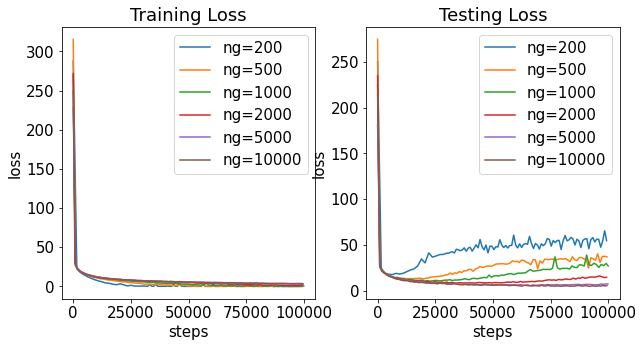

In [78]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
for ng in thedata:
#     smoothed_plot(axs[0], thedata[ng]['test']['steps'], thedata[ng]['test']['precs'], label='ng={}'.format(ng), npoints=100)
#     smoothed_plot(axs[1], thedata[ng]['steps'], thedata[ng]['recalls'], label='ng={}'.format(ng), npoints=100)
    smoothed_plot(axs[0], thedata[ng]['train']['steps'], thedata[ng]['train']['losses'], label='ng={}'.format(ng), npoints=100)
    smoothed_plot(axs[1], thedata[ng]['test']['steps'], thedata[ng]['test']['losses'], label='ng={}'.format(ng), npoints=100)

axs[0].set_xlabel('steps')
axs[0].set_ylabel('loss')
axs[0].legend()

axs[1].set_xlabel('steps')
axs[1].set_ylabel('loss')
axs[1].legend()

axs[0].set_title('Training Loss')
axs[1].set_title('Testing Loss')
plt.savefig('results/ngraph.pdf')

In [67]:
# the numbers
# FIXME this is just a place holder. Use the real test.
print('ng=, precs, recalls, shd= ')
for ng in thedata:
    print('20 & {} & {:.1f} & {:.1f} & {:.1f} \\\\'
                  .format(ng,
                          thedata[ng]['test']['precs'][-10:].mean()*100,
                         thedata[ng]['test']['recalls'][-10:].mean()*100,
                         thedata[ng]['test']['shds'][-10:].mean()*1))

ng=, precs, recalls, shd= 
20 & 200 & 83.2 & 81.9 & 6.7 \\
20 & 500 & 88.7 & 86.2 & 4.8 \\
20 & 1000 & 90.4 & 88.5 & 4.0 \\
20 & 2000 & 92.7 & 90.5 & 3.2 \\
20 & 5000 & 94.9 & 93.4 & 2.2 \\
20 & 10000 & 97.0 & 93.7 & 1.8 \\


In [72]:
# the numbers
# FIXME this is just a place holder. Use the real test.
print('ng=, precs, recalls, shd= ')
for ng in thedata10:
    print('{} & 10 & {:.1f} & {:.1f} & {:.1f} &'
                  .format(ng,
                          thedata10[ng]['test']['precs'][-10:].mean()*100,
                         thedata10[ng]['test']['recalls'][-10:].mean()*100,
                         thedata10[ng]['test']['shds'][-10:].mean()*1))
    print('   20 & {:.1f} & {:.1f} & {:.1f} \\\\'
                  .format(
                          thedata[ng]['test']['precs'][-10:].mean()*100,
                         thedata[ng]['test']['recalls'][-10:].mean()*100,
                         thedata[ng]['test']['shds'][-10:].mean()*1))

ng=, precs, recalls, shd= 
200 & 10 & 85.4 & 80.8 & 3.0 &
   20 & 83.2 & 81.9 & 6.7 \\
500 & 10 & 88.8 & 88.4 & 2.1 &
   20 & 88.7 & 86.2 & 4.8 \\
1000 & 10 & 92.2 & 90.5 & 1.6 &
   20 & 90.4 & 88.5 & 4.0 \\
2000 & 10 & 94.2 & 92.5 & 1.2 &
   20 & 92.7 & 90.5 & 3.2 \\
5000 & 10 & 95.5 & 95.0 & 0.9 &
   20 & 94.9 & 93.4 & 2.2 \\
10000 & 10 & 96.3 & 95.7 & 0.7 &
   20 & 97.0 & 93.7 & 1.8 \\


# Ensemble on different d

In [154]:
def ensD_tf_name(model, ds):
    f = 'tensorboard_logs/test-{}-CH3-d=[{}]-ensemble'.format(model, ','.join([str(d) for d in ds]))
    # assume only one file in each folder
    #     assert len(os.listdir(f)) == 1
    # FIXME whether this is in time order?
    return sorted([os.path.join(f,x) for x in os.listdir(f)])
#     f = os.path.join(f, [0])
#     return f

In [155]:
ensD_tf_name('EQ2', [10,15,20])

['tensorboard_logs/test-EQ2-CH3-d=[10,15,20]-ensemble/events.out.tfevents.1.610278334493177e9.131d07febb67']

In [156]:
ensD_tf_name('EQ2', [20,30,40])

['tensorboard_logs/test-EQ2-CH3-d=[20,30,40]-ensemble/events.out.tfevents.1.610292283963821e9.sz',
 'tensorboard_logs/test-EQ2-CH3-d=[20,30,40]-ensemble/events.out.tfevents.1.610343069269048e9.sz',
 'tensorboard_logs/test-EQ2-CH3-d=[20,30,40]-ensemble/events.out.tfevents.1.610380766955734e9.sz']

In [157]:
d1 = read_tf_data(ensD_tf_name('EQ2', [10,15,20]))

In [158]:
d2 = read_tf_data(ensD_tf_name('EQ2', [20,30,40]))

In [159]:
d1cnn = read_tf_data(ensD_tf_name('CNN', [10,15,20]))

In [160]:
d2cnn = read_tf_data(ensD_tf_name('CNN', [20,30,40]))

In [161]:
d2['steps'].size

4309

In [162]:
d1['steps'].size

288

In [163]:
idx1 = range(1, d1['steps'].size)

In [164]:
# evenly intercept d2 just d1 size
# TODO abstract this and apply in place of smoothing
idx2 = range(1, d2['steps'].size, round(d2['steps'].size / d1['steps'].size))

In [ ]:
d2['steps'][idx2]

In [165]:
def smoothed_plot(ax, x, y, label=''):
    xnew = np.linspace(x.min(), x.max(), int(round(len(x) / 2)))
    spl = make_interp_spline(x, y, k=3)  # type: BSpline
    ynew = spl(xnew)
    ax.plot(xnew, ynew, label=label)

In [166]:
def smoothed_plot(ax, x, y, label=''):
    ax.plot(x, y, label=label)

In [167]:
def plot_subfig(ax, label, which, thedata, idx):
    # smoothing
    smoothed_plot(ax, thedata['steps'][idx], thedata[which][idx], label=label)
#     smoothed_plot(ax, thedata['steps'], thedata[which], label='CNN-{}'.format(d))
    ax.set_xlabel('steps')
    ax.set_ylabel(which)
    ax.legend()
#     ax.set_title('{} for d={}'.format(which, d))

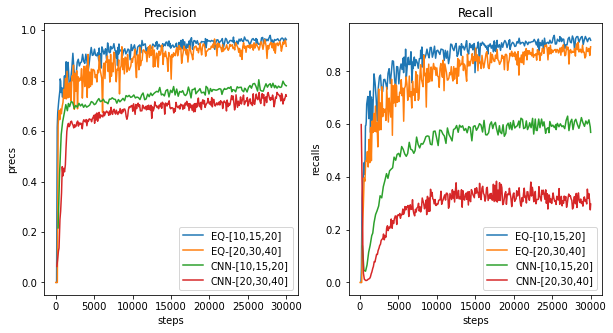

In [168]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
plot_subfig(axs[0], 'EQ-[10,15,20]', 'precs', d1, idx1)
plot_subfig(axs[0], 'EQ-[20,30,40]', 'precs', d2, idx2)
plot_subfig(axs[0], 'CNN-[10,15,20]', 'precs', d1cnn, range(3, d1cnn['steps'].size))
plot_subfig(axs[0], 'CNN-[20,30,40]', 'precs', d2cnn, range(3, d2cnn['steps'].size))

plot_subfig(axs[1], 'EQ-[10,15,20]', 'recalls', d1, idx1)
plot_subfig(axs[1], 'EQ-[20,30,40]', 'recalls', d2, idx2)
plot_subfig(axs[1], 'CNN-[10,15,20]', 'recalls', d1cnn, range(3, d1cnn['steps'].size))
plot_subfig(axs[1], 'CNN-[20,30,40]', 'recalls', d2cnn, range(3, d2cnn['steps'].size))

axs[0].set_title('Precision')
axs[1].set_title('Recall')
plt.savefig('results/ensemble-d.pdf')

In [169]:
# the numbers
# FIXME this is just a place holder. Use the real test.
for data in [d1, d2, d1cnn, d2cnn]:
    print('d=, mat=, precs, recalls, shd=   {:.1f} & {:.1f} & {:.1f}'
                  .format(
                          data['precs'][-10:].mean()*100,
                         data['recalls'][-10:].mean()*100,
                         data['shds'][-10:].mean()*1))

d=, mat=, precs, recalls, shd=   96.3 & 92.2 & 1.7
d=, mat=, precs, recalls, shd=   94.6 & 87.8 & 5.1
d=, mat=, precs, recalls, shd=   77.9 & 59.9 & 8.3
d=, mat=, precs, recalls, shd=   73.2 & 31.3 & 23.6


# ensemble on different k, and compare MAT

In [8]:
def mat_tf_name(d, mat):
    f = 'tensorboard_logs/test-EQ-d={}-mat={}-ensemble'.format(d, mat)
    # assume only one file in each folder
    assert len(os.listdir(f)) == 1
    f = os.path.join(f, os.listdir(f)[0])
    return f

In [45]:
data = {}
for d in [20,50]:
    data[d] = {}
    for mat in ['CH3', 'COV', 'COR']:
        data[d][mat] = read_tf_data(mat_tf_name(d, mat))

In [27]:
def smoothed_plot(ax, x, y, label=''):
    xnew = np.linspace(x.min(), x.max(), int(round(len(x) / 2)))
    spl = make_interp_spline(x, y, k=2)  # type: BSpline
    ynew = spl(xnew)
    ax.plot(xnew, ynew, label=label)

In [30]:
def smoothed_plot(ax, x, y, label=''):
    ax.plot(x, y, label=label)

In [33]:
def plot_subfig(ax, d, which, data):
    # smoothing
    smoothed_plot(ax, data[d]['CH3']['steps'], data[d]['CH3'][which], label='COR+norm(COV)')
    smoothed_plot(ax, data[d]['COR']['steps'], data[d]['COR'][which], label='COR')
    smoothed_plot(ax, data[d]['COV']['steps'], data[d]['COV'][which], label='COV')
    ax.set_xlabel('steps')
    ax.set_ylabel(which)
    ax.legend()
    ax.set_title('{} for d={}'.format(which, d))

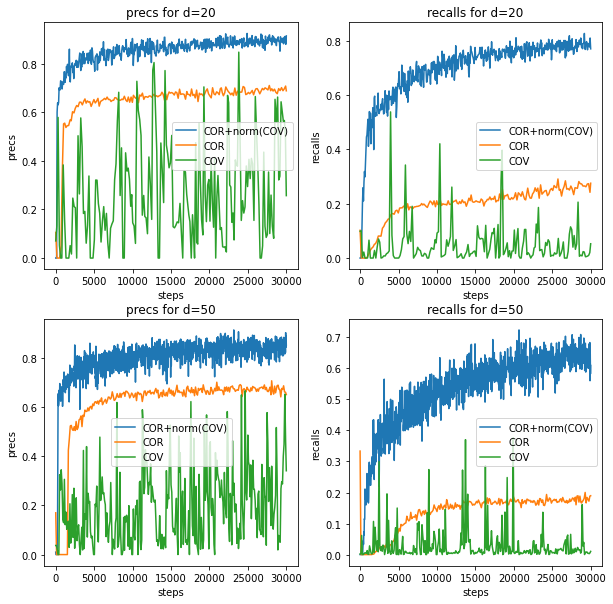

In [34]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
plot_subfig(axs[0,0], 20, 'precs', data)
plot_subfig(axs[0,1], 20, 'recalls', data)
plot_subfig(axs[1,0], 50, 'precs', data)
plot_subfig(axs[1,1], 50, 'recalls', data)
plt.savefig('results/mat.pdf')

In [38]:
# get the values. Use the average of last 10 values
data[20]['CH3']['precs'][-10:].mean()

0.8990789353847504

In [50]:
# FIXME this is just a place holder. Use the real test.
for d in [20,50]:
    for mat in ['CH3', 'COR', 'COV']:
        print('d={}, mat={}, precs, recalls, shd=   {:.1f} & {:.1f} & {:.1f}'
              .format(d, mat, 
                      data[d][mat]['precs'][-10:].mean()*100,
                     data[d][mat]['recalls'][-10:].mean()*100,
                     data[d][mat]['shds'][-10:].mean()*1))

d=20, mat=CH3, precs, recalls, shd=   89.9 & 78.3 & 5.9
d=20, mat=COR, precs, recalls, shd=   69.2 & 26.9 & 16.4
d=20, mat=COV, precs, recalls, shd=   50.2 & 1.7 & 19.5
d=50, mat=CH3, precs, recalls, shd=   86.0 & 62.5 & 23.6
d=50, mat=COR, precs, recalls, shd=   66.9 & 18.1 & 44.8
d=50, mat=COV, precs, recalls, shd=   32.7 & 0.9 & 57.9


# training process

In [7]:
os.listdir("tensorboard_logs")

['test-EQ2-ERSF-k1-d=50-ensemble',
 'test-FC-ERSF-k1-d=100-ensemble',
 'test-CNN-ERSF-k1-d=20-ensemble',
 'test-FC-ERSF-k1-d=20-ensemble',
 'test-CNN-ERSF-k1-d=10-ensemble',
 '.ipynb_checkpoints',
 'test-EQ2-ERSF-k1-d=20-ensemble',
 'test-EQ2-ERSF-k1-d=10-ensemble',
 'test-CNN-ERSF-k1-d=100-ensemble',
 'test-FC-ERSF-k1-d=50-ensemble',
 'test-EQ2-ERSF-k1-d=100-ensemble',
 'test-CNN-ERSF-k1-d=50-ensemble',
 'test-FC-ERSF-k1-d=10-ensemble']

In [ ]:
def train_process_tf_name(model, d):
    f = 'tensorboard_logs/test-{}-ERSF-k1-d={}-ensemble'.format(model, d)
    # assume only one file in each folder
    assert len(os.listdir(f)) == 1
    f = os.path.join(f, os.listdir(f)[0])
    return f

In [28]:
fc10 = read_tf_data(train_process_tf_name('FC', 10))

In [29]:
fc10['steps']

array([    1,     2,   149,   385,   627,   873,  1124,  1378,  1640,
        1898,  2157,  2417,  2677,  2935,  3192,  3453,  3713,  3980,
        4247,  4511,  4772,  5035,  5299,  5558,  5823,  6086,  6355,
        6623,  6897,  7167,  7430,  7691,  7956,  8221,  8485,  8745,
        9008,  9276,  9550,  9816, 10083, 10349, 10612, 10875, 11137,
       11399, 11664, 11931, 12204, 12470, 12734, 12995, 13260, 13524,
       13789, 14051, 14320, 14591, 14861, 15123, 15386, 15611, 15872,
       16137, 16402, 16666, 16934, 17206, 17476, 17743, 18001, 18267,
       18532, 18797, 19058, 19326, 19597, 19870, 20137, 20404, 20670,
       20932, 21198, 21463, 21728, 21994, 22269, 22539, 22805, 23066,
       23332, 23596, 23858, 24118, 24382, 24651, 24925, 25193, 25457,
       25722, 25988, 26249, 26515, 26778, 27045, 27310, 27584, 27856,
       28122, 28381, 28647, 28911, 29177, 29438, 29702, 29974, 30000])

In [30]:
len(fc10['steps'])

117

In [59]:
fc20 = read_tf_data(train_process_tf_name('FC', 20))
fc50 = read_tf_data(train_process_tf_name('FC', 50))
cnn20 = read_tf_data(train_process_tf_name('CNN', 20))
cnn50 = read_tf_data(train_process_tf_name('CNN', 50))
eq20 = read_tf_data(train_process_tf_name('EQ2', 20))
eq50 = read_tf_data(train_process_tf_name('EQ2', 50))

In [ ]:
# plot it
x = np.linspace(steps.min(), steps.max(), 20)
spl = make_interp_spline(steps, precs, k=3)  # type: BSpline
y = spl(x)

plt.plot(x, y)

In [49]:
def smoothed_plot(ax, x, y, label=''):
    xnew = np.linspace(x.min(), x.max(), int(round(len(x) / 2)))
    spl = make_interp_spline(x, y, k=2)  # type: BSpline
    ynew = spl(xnew)
    ax.plot(xnew, ynew, label=label)

In [60]:
def smoothed_plot(ax, x, y, label=''):
    ax.plot(x, y, label=label)

In [61]:
def plot_subfig(ax, d, which, eq, fc, cnn):
    # smoothing
    smoothed_plot(ax, eq['steps'], eq[which], label='EQ')
    smoothed_plot(ax, fc['steps'], fc[which], label='FC')
    smoothed_plot(ax, cnn['steps'], cnn[which], label='CNN')
    ax.set_xlabel('steps')
    ax.set_ylabel(which)
    ax.legend()
    ax.set_title('{} for d={}'.format(which, d))

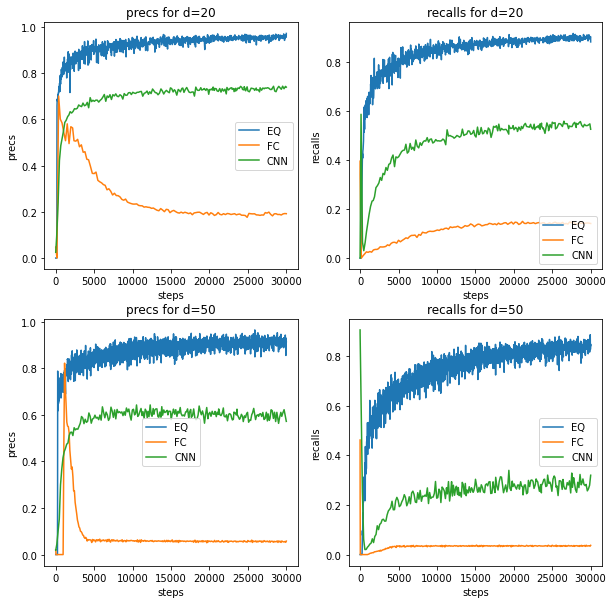

In [63]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
plot_subfig(axs[0,0], 20, 'precs', eq20, fc20, cnn20)
plot_subfig(axs[0,1], 20, 'recalls', eq20, fc20, cnn20)
plot_subfig(axs[1,0], 50, 'precs', eq50, fc50, cnn50)
plot_subfig(axs[1,1], 50, 'recalls', eq50, fc50, cnn50)
plt.savefig('results/training_process.pdf')